<a href="https://colab.research.google.com/github/alvarofpinheiro/pifwia_nsga2/blob/main/PIFWIA_NSGA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NSGA2 - Non-dominated Sorting Genetic Algorithm ou Algoritmo Genético de Classificação Não Dominado é uma metaheurística para otimização multiobjetivo que pode ser denominada de "programação multiobjetivo" ou "otimização vetorial" ou "otimização multicritério" ou "otimização multiatributo" ou "otimização de Pareto", sendo uma área de tomada de decisão com múltiplos objetivos a serem otimizados simultaneamente de dois ou mais objetivos conflitantes.

Deb, K.; Pratap, A.; Agarwal, S.; Meyarivan, T. A fast and elitist multiobjective genetic algorithm: NSGA-II. IEEE Transactions on Evolutionary Computation (Volume: 6, Issue: 2). https://doi.org/10.1109/4235.996017, 2002.

pymoo: Multi-objective Optimization in Python https://pymoo.org/

In [ ]:
#instala biblioteca Orange Canvas e pymoo (otimização multiobjetivo)
!pip install Orange3
!pip install pymoo

In [ ]:
#importa bibliotecas
import Orange
import random
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy.random import choice
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem, get_reference_directions, get_visualization
from pymoo.visualization.star_coordinate import StarCoordinate
from pymoo.util.plotting import plot
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from tqdm import tqdm

In [ ]:
#define os hiperparâmetros
OBJETIVOS = ["Eficiência","Eficácia"] #quantidade de objetivos distintos a serem resolvidos
DIMENSOES = 3 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos (episódios) especificando quantas explorações podem ser realizadas
POPULACAO = 10 #tamanho da população correspondente ao indivíduo
E1 = -100 #extremo esquerdo eixo x
E2 = 100 #extremo direito eixo x
E3 = -100 #extremo inferior eixo y
E4 = 100 #extremo superior eixo y
LIMITES = [E1, E4] #(bound) determina os valores mínimos e máximos do espaço de busca
SEMENTE=1 #valor de inicialização
INDIVIDUOS = [] #(swarm) array da criação dos indivíduos da população

In [ ]:
#importa dados
from google.colab import files  
files.upload()

Saving dados.csv to dados (1).csv


{'dados.csv': b'\xef\xbb\xbfPROCURADOR;PROCESSO;COMPLEXIDADE;PAGINA;PRAZO;REVISOES;ENTREGA;VALOR(milR$)\r\nProcurador1;2022000205;2;37;10;2;18;79\r\nProcurador2;2022000229;2;2;5;4;16;56\r\nProcurador3;2022000243;4;82;15;2;28;81\r\nProcurador4;2022000305;2;17;10;4;36;64\r\nProcurador5;2022000413;3;11;10;1;9;23\r\nProcurador6;2022000448;2;48;10;5;45;84\r\nProcurador7;2022000480;1;18;10;3;27;30\r\nProcurador8;2022000487;1;3;5;1;4;93\r\nProcurador9;2022000622;2;4;5;2;8;61\r\nProcurador10;2022000631;1;7;5;5;20;4\r\nProcurador11;2022000751;2;27;10;5;45;53\r\nProcurador12;2022000776;2;48;10;3;27;31\r\nProcurador13;2022000843;3;89;15;1;14;46\r\nProcurador14;2022001097;4;11;10;4;36;97\r\nProcurador15;2022000192;1;6;5;5;20;68\r\nProcurador16;2022000274;3;64;15;1;14;32\r\nProcurador17;2022000387;3;18;10;2;18;59\r\nProcurador18;2022000388;3;5;5;1;4;29\r\nProcurador19;2022000572;4;73;15;5;70;20\r\nProcurador20;2022000747;2;7;5;4;16;75\r\nProcurador21;2022000895;2;49;10;1;9;89\r\nProcurador22;202200

In [ ]:
#instancia objeto de dados com base no caminho gerado na importação do arquivo
dados = Orange.data.Table("/content/dados.csv")
#explora os metadados e dados da arquivo importado
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
dados.domain.attributes #explora os domínios dos atributos (campos da base de dados)
print("Registros:", len(dados)) #explora os dados (quantidade de registros da base de dados)
i = 0 #exibe os primeiros registros para análise dos dados importados
for d in dados[:20]:
  i += 1
  #print(i, d)
#cria arrays das dimensões do problema a ser otimizado
procurador = []
processo = []
complexidade = [] #1-muito baixa complexidade;2-baixa complexidade;3-média complexidade;4-alta complexidade;e,5-muito alta complexidade
pagina = []
prazo = []
revisao = []
entrega = []
valor = []
i = 0
for d in dados[:POPULACAO]:
  procurador.append(d[0])
  processo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
  valor.append(d[7])
  #print("id:",i,"procurador:",procurador[i],"processo:",processo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i],"valor:",valor[i])
  i += 1
#definição dos pesos da função objetivo
PESOS = [0.2,0.2,0.1,0.1,0.1,0.3] #f(x) = (0.2α + 0.2β + 0.1γ + 0.1δ + 0.1ε + 0.3θ) / 0.10
pesos = []
for i in range(DIMENSOES):
  pesos.append(PESOS[i])
print(pesos)

8 metadados: 7 continuos, 1 discretos
Nome dos metadados: PROCURADOR, PROCESSO, COMPLEXIDADE, PAGINA, PRAZO, REVISOES, ENTREGA, VALOR(milR$)
Registros: 1013
[0.2, 0.2, 0.1]


In [ ]:
#inicializa população (indivíduos)
populacao = []
for i in range(POPULACAO):
  cpx = complexidade[i]
  pag = pagina[i]
  prz = prazo[i]
  rev = revisao[i]
  ent = entrega[i]
  val = valor[i]
  posicao = 0
  individuo = []
  for j in range(DIMENSOES):
    if (j==0):
      posicao = cpx
    elif (j==1):
      posicao = pag
    elif (j==2):
      posicao = prz
    elif (j==3):
      posicao = rev
    elif (j==4):
      posicao = ent
    elif (j==5):
      posicao = val
    else:
      posicao = random.random()*(LIMITES[1]-LIMITES[0]) - LIMITES[1]
    individuo.append(posicao)
  populacao.append(individuo)
  INDIVIDUOS = np.array(populacao)
  aux = ""
  for p in range(len(pesos)):
    aux += str(pesos[p]) + ", "
  print("indivíduo:",i,"indivíduo:",populacao[i],"pesos:",aux)

indivíduo: 0 indivíduo: [Value('COMPLEXIDADE', 2), Value('PAGINA', 37), Value('PRAZO', 10)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 1 indivíduo: [Value('COMPLEXIDADE', 2), Value('PAGINA', 2), Value('PRAZO', 5)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 2 indivíduo: [Value('COMPLEXIDADE', 4), Value('PAGINA', 82), Value('PRAZO', 15)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 3 indivíduo: [Value('COMPLEXIDADE', 2), Value('PAGINA', 17), Value('PRAZO', 10)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 4 indivíduo: [Value('COMPLEXIDADE', 3), Value('PAGINA', 11), Value('PRAZO', 10)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 5 indivíduo: [Value('COMPLEXIDADE', 2), Value('PAGINA', 48), Value('PRAZO', 10)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 6 indivíduo: [Value('COMPLEXIDADE', 1), Value('PAGINA', 18), Value('PRAZO', 10)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 7 indivíduo: [Value('COMPLEXIDADE', 1), Value('PAGINA', 3), Value('PRAZO', 5)] pesos: 0.2, 0.2, 0.1, 
indivíduo: 8 indivíduo: [Value('COMPLEXIDADE', 2), Value('PAGINA', 4), Value('PRAZO'

In [ ]:
#define a função de calculo
def calcula(exibe):
  problema = get_problem(FCUSTO)
  pareto = problema.pareto_front()
  algoritmo = NSGA2(
    ref_points=INDIVIDUOS,
    pop_size=POPULACAO,
    eliminate_duplicates=True,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False,
    weights=np.array(pesos))
  resultado = minimize(problema, #objeto Problema que contém o problema a ser resolvido
    algoritmo, #objetivo de algoritmo que representa o algoritmo a ser usado
    save_history=True, #um valor booleano que representa se um instantâneo do algoritmo deve ser armazenado em cada iteração
    termination=('n_gen',ITERACOES), #um objeto que define quando o algoritmo termina
    seed=SEMENTE, #semente com valor inteiro positivo garante resultados reproduzíveis 
    pf=pareto, #define o ploblema de pareto
    disp=True, #você pode substituir qual saída deve ser impressa em cada iteração
    verbose=exibe) #valor booleano que define se a saída deve ser impressa durante a execução ou não
  return (pareto,resultado)

In [ ]:
#calcula a otimização
c1dtlz = ['c1dtlz1', 'c1dtlz3', 'c2dtlz2', 'c3dtlz1', 'c3dtlz4']
convex = ['convex_dtlz2', 'convex_dtlz4']
ctp = ['ctp1', 'ctp2', 'ctp3', 'ctp4', 'ctp5', 'ctp6', 'ctp7', 'ctp8']
dascmop = ['dascmop1', 'dascmop2', 'dascmop3', 'dascmop4', 'dascmop5', 'dascmop6', 'dascmop7', 'dascmop8', 'dascmop9'] #conjunto de testes multiobjetivo restrito com restrições ajustáveis
dc1dtlz = ['dc1dtlz1', 'dc1dtlz3', 'dc2dtlz1', 'dc2dtlz3', 'dc3dtlz1', 'dc3dtlz3'] #para problemas de convergência em hiperplano de Pareto-ótimo
dtlz = ['dtlz1^-1', 'dtlz1', 'dtlz2', 'dtlz3', 'dtlz4', 'dtlz5', 'dtlz6', 'dtlz7']
g = ['g01', 'g02', 'g03', 'g04', 'g05', 'g06', 'g07', 'g08', 'g09', 'g10']
mw = ['mw1', 'mw2', 'mw3', 'mw4', 'mw5', 'mw6', 'mw7', 'mw8', 'mw9', 'mw10', 'mw11', 'mw12', 'mw13', 'mw14'] #conjunto multi-objetivo restrito construído para problemas com até 4 restrições de desigualdade
wfg = ['wfg1', 'wfg2', 'wfg3', 'wfg4', 'wfg5', 'wfg6', 'wfg7', 'wfg8', 'wfg9']
zdt = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt5', 'zdt6'] #dois objetivos devem ser minimizados
outros = ['rosenbrock', 'schwefel', 'sphere', 'srn', 'tnk', 'truss2d', 'welded_beam', 'zakharov','ackley', 'bnh', 'carside','modact','sdtlz1','cantilevered_beam', 'griewank', 'himmelblau', 'knp', 'kursawe', 'osy', 'pressure_vessel', 'rastrigin']
FCUSTO=dtlz[1]
pareto,resultado=calcula(True)

n_gen |  n_eval |     igd      |      gd     
    1 |      10 |  5.94504E+01 |  2.94439E+02
    2 |      20 |  5.94504E+01 |  3.10747E+02
    3 |      30 |  5.94504E+01 |  3.04733E+02
    4 |      40 |  5.94504E+01 |  2.21248E+02
    5 |      50 |  5.94504E+01 |  2.14018E+02
    6 |      60 |  5.94504E+01 |  2.39304E+02
    7 |      70 |  1.40955E+02 |  2.95672E+02
    8 |      80 |  8.61645E+01 |  2.66164E+02
    9 |      90 |  8.61645E+01 |  2.79505E+02
   10 |     100 |  6.15885E+01 |  2.09097E+02
   11 |     110 |  6.15885E+01 |  1.50069E+02
   12 |     120 |  6.15885E+01 |  1.47792E+02
   13 |     130 |  6.15885E+01 |  1.49986E+02
   14 |     140 |  6.15885E+01 |  1.43938E+02
   15 |     150 |  6.15885E+01 |  1.52542E+02
   16 |     160 |  6.15885E+01 |  1.51558E+02
   17 |     170 |  6.15885E+01 |  1.38245E+02
   18 |     180 |  4.58168E+01 |  1.34301E+02
   19 |     190 |  4.58168E+01 |  9.98971E+01
   20 |     200 |  4.58168E+01 |  1.08805E+02
   21 |     210 |  4.58168E+01 |  

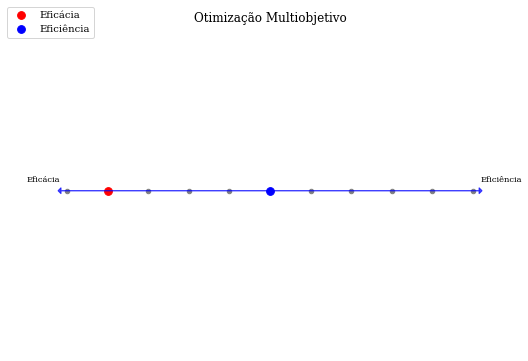

In [ ]:
#plota o resultado dos valores de espaços objetivos (resultado.F)
approx_ideal = resultado.F.min(axis=0)
approx_nadir = resultado.F.max(axis=0)
solucao = []
for i in range(len(OBJETIVOS)):
  try:
    pnt = int(str(approx_ideal[i])[0:1])
  except:
    pnt = 1
  if (len(OBJETIVOS)>2):
    if (i>0):
      pnt = pnt + POPULACAO * (i*len(OBJETIVOS))
  solucao.append(pnt)
rotulo = []
cores = ["red","blue","black","green","pink","brown"]
DIRECAO = get_reference_directions("uniform", len(OBJETIVOS), n_partitions=POPULACAO)
F = get_problem(FCUSTO).pareto_front(DIRECAO)
SC = StarCoordinate(title="Otimização Multiobjetivo", 
  legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
  labels=OBJETIVOS,
  axis_style={"color": "blue", 'alpha': 0.7},
  arrow_style={"head_length": 0.015, "head_width": 0.03})
SC.add(F, color="grey", s=20)
j = len(OBJETIVOS)-1
for i in range(len(OBJETIVOS)):
  SC.add(F[solucao[i]], color=cores[i], s=60, label=OBJETIVOS[j-i])
SC.show()

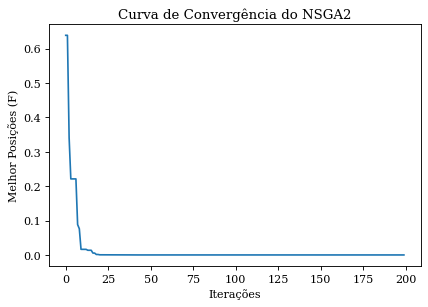

In [ ]:
#exibe curva de convergência dos indivíduos
retorno = [np.min(e.pop.get("F")) for e in resultado.history] #cria conjunto de dados
plt.figure(figsize=(6,4), dpi=80) #cria figura com tamanho de 8x6 pontos com 80 pontos por polegada
plt.subplot(1, 1, 1) #cria nova subplotagem a partir de um grid de 1x1
plt.title("Curva de Convergência do NSGA2")
plt.xlabel("Iterações")
plt.ylabel("Melhor Posições (F)")
plt.plot(np.arange(len(retorno)), retorno) #plota x e y
plt.show()

In [ ]:
#exibe os resultados
print("n_gen=número de iterações (gerações) | n_eval=número de avaliações | igd=desempenho distância geracional invertida | gd=desempenho da distância geracional | hv=hypervolume")
#resultados F
for i in range(POPULACAO):
  print("i:",i,"espaços objetivos:",resultado.F[i])
#resultados pop
popfim = resultado.pop
popfimF = popfim.get("F")
popfimX = popfim.get("X")
for i in range(POPULACAO):
  print("i:",i,"população final F=espeço objetivo:",popfimF[i])
for i in range(POPULACAO):
  print("i:",i,"população final X=espeço de busca:",popfimX[i])
#resultados X
for i in range(POPULACAO):
  print("i:",i,"espaço de design:",resultado.X[i])
#resultados G
for i in range(POPULACAO):
  print("i:",i,"valores de restrição:",resultado.G[i])
#resultados CV
for i in range(POPULACAO):
  print("i:",i,"violação de restrição agregada:",resultado.CV[i])
#resultados opt
sol = resultado.opt
solF = sol.get("F")
solX = sol.get("X")
for i in range(POPULACAO):
  print("i:",i,"soluções:",solF[i])
#resultados history
his = resultado.history
for i in range(ITERACOES):
  ele = his[i]
  print("i:",i,"elemento:",ele)